In [28]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew
from subprocess import check_output
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
color = sns.color_palette()
sns.set_style('darkgrid')

pd.pandas.set_option('display.max_columns',None) 
import pandas.util.testing as tm

from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [4]:
#reading dataframe
data = pd.read_excel('creditcard.xlsb', engine='pyxlsb')

In [10]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
#data has zero missing values

#### EDA

Distribuition of Normal(0) and Frauds(1): 
0    284315
1       492
Name: Class, dtype: int64


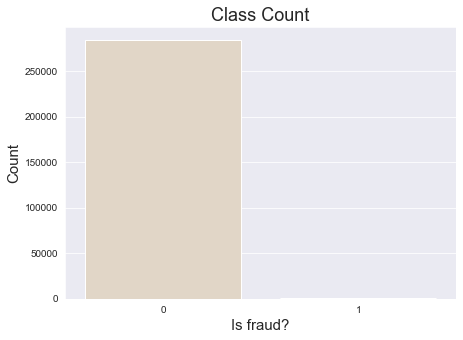

In [8]:
#Lets start looking the difference by Normal and Fraud transactions
print("Distribuition of Normal(0) and Frauds(1): ")
print(data["Class"].value_counts())
plt.figure(figsize=(7,5))
sns.countplot(data["Class"], palette = 'ch:.25')
plt.title("Class Count", fontsize=18)
plt.xlabel("Is fraud?", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

#### Time Features and some Feature Engineering

As our Time feature are in seconds we will transform it ot minutes and hours to get a better understand of the patterns

In [12]:
timedelta = pd.to_timedelta(data['Time'], unit = 's')
data['Time_min'] = (timedelta.dt.components.minutes).astype(int)
data['Time_hr'] = (timedelta.dt.components.hours).astype(int)

No handles with labels found to put in legend.


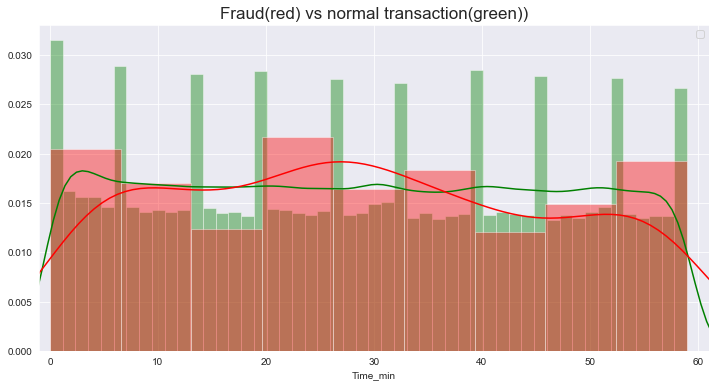

In [23]:
plt.figure(figsize = (12,6))

sns.distplot( data[data["Class"] == 0]['Time_min'] ,  color = 'g')
sns.distplot( data[data["Class"] == 1]['Time_min'], color = 'r')
plt.title('Fraud(red) vs normal transaction(green)) by minutes', fontsize = 17)
plt.legend()
                        
plt.xlim(-1,61)
plt.show()

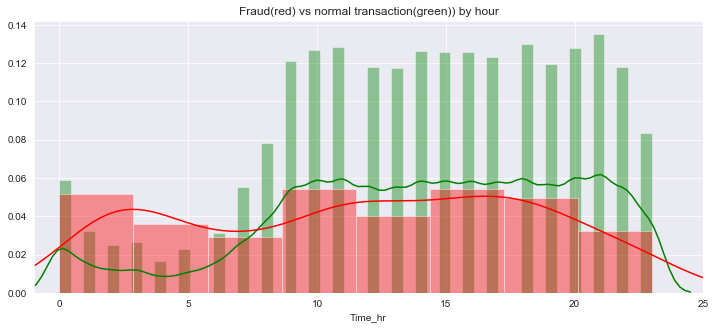

In [25]:
plt.figure(figsize = (12,5))

sns.distplot(data[data["Class"]== 0]['Time_hr'], color = 'g')
sns.distplot(data[data['Class']==1]['Time_hr'], color= 'r')
plt.title("Fraud(red) vs normal transaction(green)) by hour")

plt.xlim(-1,25)
plt.show()

We can see that the fraud transation is not much dependent on the time period.

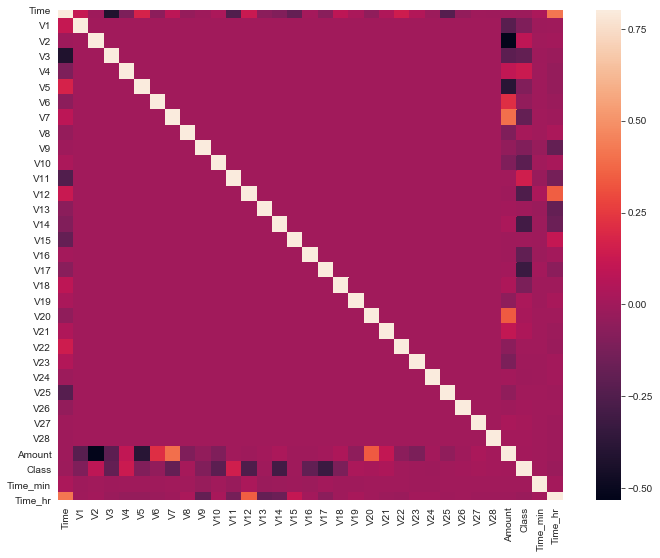

In [26]:
correlation_matrix = data.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

correlation matrix shows that none of the V1 to V28 PCA components have any correlation to each other

In [34]:
Fraud = data[data['Class']==1]
Valid = data[data['Class']==0]
outlier_fraction = len(Fraud)/float(len(Valid))

In [35]:
X = data.drop(["Class"], axis = 1)
Y = data["Class"]

# Define a random state 
state = np.random.RandomState(42)
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))

The types of algorithms we are going to use to try to do anomaly detection on this dataset are as follows

1. Isolation Forest Algorithm:
2. Local Oulier Factor Algorithm
3. Support Vector Machine(SVM)

In [36]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1, random_state=state)
   
}

In [ ]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

C:\Users\sibin\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Isolation Forest: 685
Accuracy Score :
0.9975948624858237
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.30      0.30      0.30       492

    accuracy                           1.00    284807
   macro avg       0.65      0.65      0.65    284807
weighted avg       1.00      1.00      1.00    284807

Local Outlier Factor: 937
Accuracy Score :
0.9967100527725793
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.05      0.05      0.05       492

    accuracy                           1.00    284807
   macro avg       0.52      0.52      0.52    284807
weighted avg       1.00      1.00      1.00    284807



C:\Users\sibin\Anaconda3\lib\site-packages\sklearn\svm\classes.py:1194: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)
